In [1]:
import librosa
import librosa.display
import pretty_midi_fluidsynth as pmf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
model = tf.keras.models.load_model(
    './checkpoint/class1_best_model'
)

In [3]:
x, sr = librosa.load('out.wav',sr=None)
print(sr)

44100


In [4]:
print(x.shape)

(14469120,)


In [5]:
pad_len = 44100-x.shape[0]%44100
print(pad_len)

x = np.pad(x,(0,pad_len))
print(x.shape)

39780
(14508900,)


In [6]:
print(x.shape[0]/44100)

329.0


In [7]:
hop_len = 441 # sr//100
freq_w = 4
octave = 8

fs = 25

start_pitch = 24
end_pitch = 120

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

pr_n_bins = end_pitch - start_pitch

assert(n_bins//freq_w==pr_n_bins)

In [8]:
cqt = librosa.cqt(x, sr=sr,
                  hop_length= hop_len,
                  n_bins= 12*freq_w*octave,
                  bins_per_octave= 12*freq_w,
                 )

In [9]:
cqt = librosa.amplitude_to_db(np.abs(cqt),ref=np.max)/80+1

In [10]:
cqt.shape

(384, 32901)

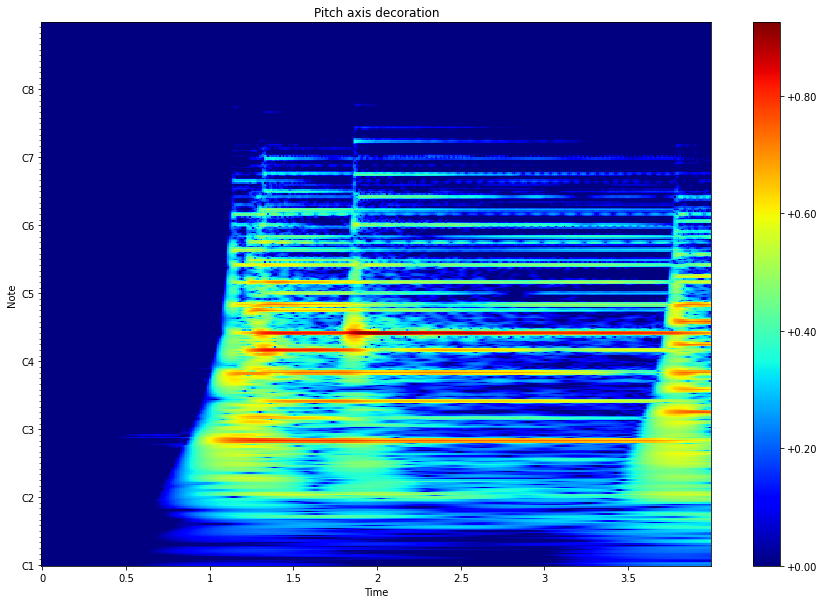

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    cqt[:,800:1200], sr=sr,
    x_axis='time',
    y_axis='cqt_note',
    ax=ax,
    hop_length= hop_len,
    bins_per_octave= 12*freq_w,
    cmap='jet'
)
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2.2f")

plt.show()

In [12]:
pad_len = 400-cqt.shape[1]%400
print(pad_len)
y = np.pad(cqt,[(0,0),(0,pad_len)])
print(y.shape)

299
(384, 33200)


In [13]:
inputs = []
for i in range(y.shape[1]//400):
    inputs.append(y[:,400*i:400*(i+1)])
inp = np.array(inputs)

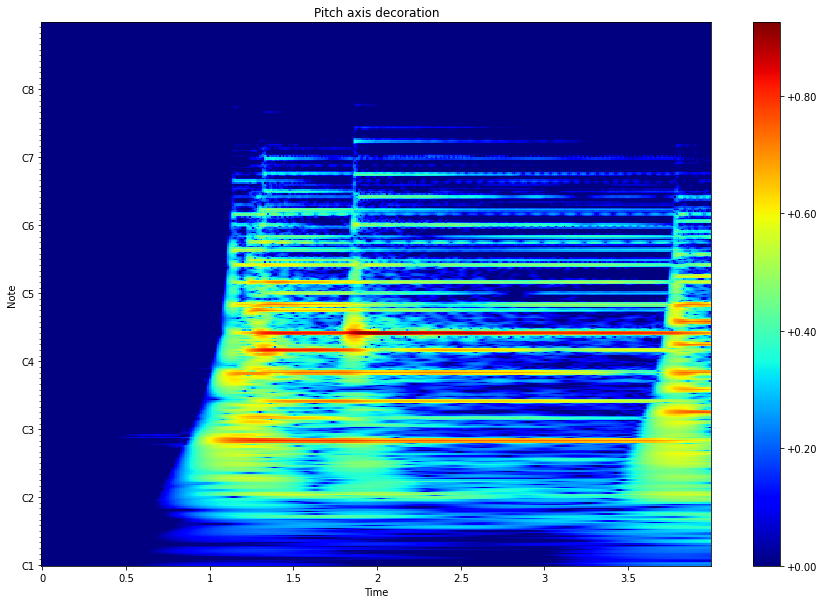

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    inp[2], sr=sr,
    x_axis='time',
    y_axis='cqt_note',
    ax=ax,
    hop_length= hop_len,
    bins_per_octave= 12*freq_w,
    cmap='jet'
)
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2.2f")

plt.show()

In [15]:
inputs = []
for i in range(y.shape[1]//400):
    inputs.append(y[:,400*i:400*(i+1)].T)

In [16]:
pred = []
for inp in inputs:
    pred.append(model(inp[np.newaxis,:,:,np.newaxis]))
len(pred)

83

In [17]:
pr = np.squeeze(pred[0],axis=(0,-1)).T
for p in pred[1:]:
    p = np.squeeze(p,axis=(0,-1)).T
    pr = np.concatenate((pr,p), axis=-1)
pr.shape

(96, 8300)

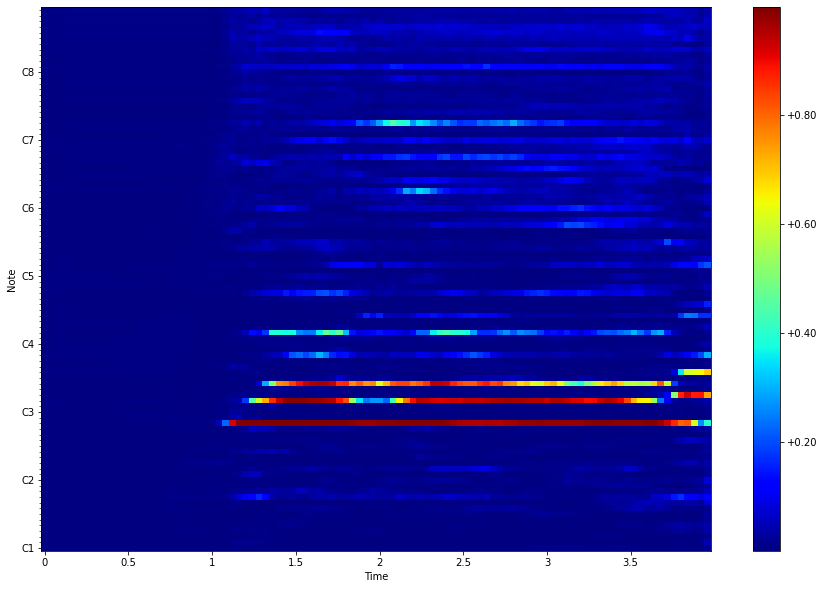

In [25]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    pr[:,200:300],
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
)
fig.colorbar(img, ax=ax, format="%+2.2f")
plt.show()

In [19]:
from scipy.ndimage import gaussian_filter

In [20]:
gau = gaussian_filter(pr, sigma=0.5)

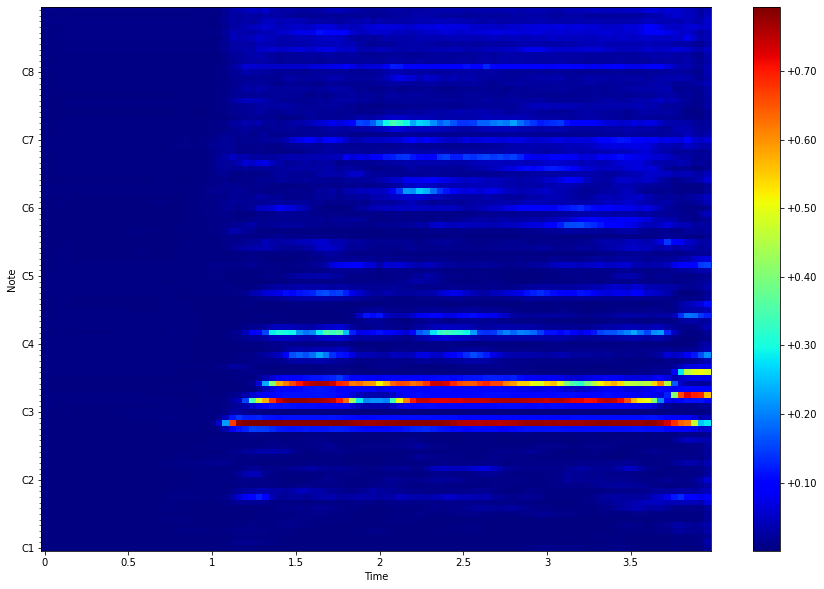

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    gau[:,200:300],
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
)
fig.colorbar(img, ax=ax, format="%+2.2f")
plt.show()

In [22]:
confidence =0.33
roll = np.where(pr>confidence,100,0)

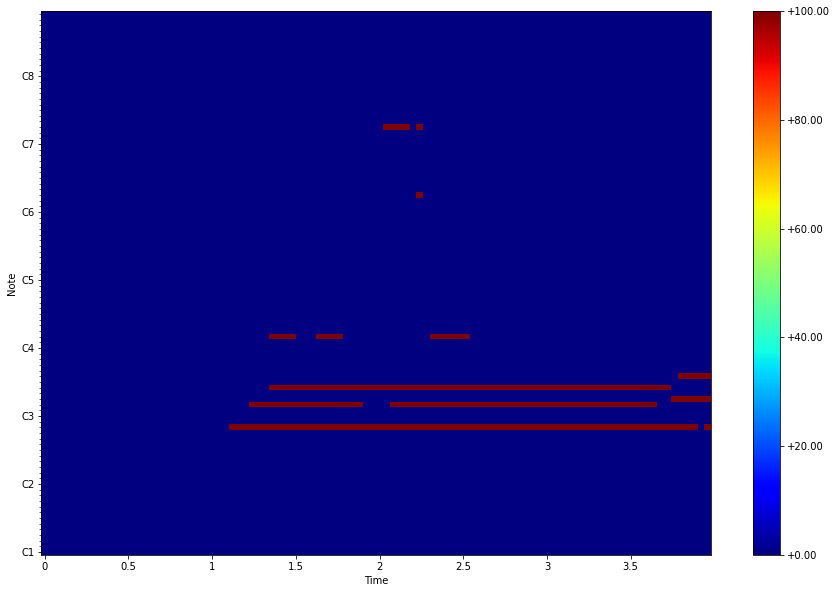

In [23]:

fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    roll[:,200:300],
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
)
fig.colorbar(img, ax=ax, format="%+2.2f")
plt.show()

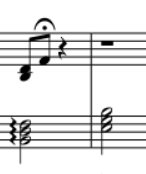